# report stats, monitor change

record properties of ``treedb.sqlite3``
loaded from [Glottolog](https://glottolog.org)
[master repo](https://github.com/glottolog/glottolog) commit
and monitor changes by diffing this

<div style="text-align: right">
  <a href="https://nbviewer.jupyter.org/github/glottolog/treedb/blob/master/Stats.ipynb">
      latest version from GitHub in nbviewer
  </a>
</div>

### contents
1. [clone/checkout](#clone/checkout)
2. [load](#load)
3. [treedb.sqlite3](#treedb.sqlite3)
4. [\_\_dataset\_\_](#__dataset__)
5. [treedb.raw](#treedb.raw)
6. [languoid](#languoid)
7. [macroarea](#macroarea)
8. [country](#country)
9. [link](#link)
10. [denormalized](#denormalized)

In [1]:
%matplotlib inline

import collections
import datetime
import functools
import logging
import logging.config
import pathlib
import subprocess

from urllib.parse import urlparse  # PY3

import pandas as pd
import sqlalchemy as sa
import matplotlib as mpl
import matplotlib.pyplot as plt

import treedb

from treedb import raw

REBUILD = False

ECHO_SQL = True

DEBUG = False

LOGGING = {
    'version': 1,
    'root': {'handlers': ['plain'], 'level': 'INFO'},
    'loggers': {'py.warnings': {'handlers': ['source'], 'propagate': False,
                                'level': 'WARNING' },
                'sqlalchemy.engine': {'level': 'WARNING'},
                'treedb': {'handlers': ['source'], 'propagate': False,
                           'level': 'INFO' if DEBUG else 'WARNING'},},
    'handlers': {'plain': {'formatter': 'format_plain', 'level': 'DEBUG',
                           'class': 'logging.StreamHandler',},
                 'source': {'formatter': 'format_source', 'level': 'DEBUG',
                            'class': 'logging.StreamHandler',},},
    'formatters': {'format_plain': {'format': '%(message)s'},
                   'format_source': {'format': '[%(levelname)s@%(name)s] %(message)s'},},
}

logging.config.dictConfig(LOGGING)
logging.captureWarnings(True)

treedb.__version__

'0.1.3'

## clone/checkout

In [2]:
%%time

TARGET = pathlib.Path('..', 'glottolog')

REPO_URL = 'https://github.com/glottolog/glottolog.git'

TAG_OR_BRANCH = 'v4.1'

SET_BRANCH = 'treedb'

CLONE_DEPTH = 1

def git_checkout(clone_if_needed=True):
    if not TARGET.exists():
        if not clone_if_needed:
            raise RuntimeError
        subprocess.run(['git', 'clone',
                        '--branch', TAG_OR_BRANCH,
                        '--depth', '%d' % CLONE_DEPTH,
                        REPO_URL, str(TARGET)], check=True)
    return subprocess.run(['git', 'checkout',
                           '-B', SET_BRANCH,
                           TAG_OR_BRANCH], cwd=TARGET, check=True)

if REBUILD or not treedb.ENGINE.file_exists():
    print(git_checkout())

CompletedProcess(args=['git', 'checkout', '-B', 'treedb', 'v4.1'], returncode=0)
Wall time: 1min 10s


## load

In [3]:
treedb.set_root(TARGET)

<treedb.proxies.PathProxy path='../glottolog/languoids/tree' inode=23362423067327622>

In [4]:
next(treedb.iterfiles())

(('abin1243',), <DirEntry 'md.ini'>, <treedb.files.ConfigParser at 0x53e0ee0>)

In [5]:
next(treedb.iterlanguoids())

(('abin1243',),
 {'id': 'abin1243',
  'parent_id': None,
  'level': 'language',
  'name': 'Abinomn',
  'hid': 'bsa',
  'iso639_3': 'bsa',
  'latitude': -2.92281,
  'longitude': 138.891,
  'macroareas': ['Papunesia'],
  'countries': [('Indonesia', 'ID')],
  'links': [{'url': 'http://endangeredlanguages.com/lang/1763',
    'title': 'Abinomn',
    'scheme': 'http'},
   {'url': 'https://www.wikidata.org/entity/Q56648',
    'title': None,
    'scheme': 'https'},
   {'url': 'https://en.wikipedia.org/wiki/Abinomn_language',
    'title': None,
    'scheme': 'https'}],
  'sources': {'glottolog': [{'bibfile': 'hh',
     'bibkey': 'e:Lagerberg:Moegip',
     'pages': None,
     'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'h:SilzerClouse:Index',
     'pages': None,
     'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'h:SilzerHeikkinen:Irian',
     'pages': None,
     'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'hv:Foley:Northwest-New-Guinea',
     'pages': None,
     '

In [6]:
%%time

engine = treedb.load('treedb.sqlite3', rebuild=REBUILD, exclude_raw=False)
engine

0:01:38.878656
Wall time: 1min 38s


<treedb.proxies.SQLiteEngineProxy filename='treedb.sqlite3' size=115171328>

In [7]:
str(datetime.datetime.fromtimestamp(engine.file.stat().st_mtime))

'2019-12-03 20:26:22.629637'

In [8]:
MB = 2**20

engine.file_size() / MB

109.8359375

In [9]:
%time engine.file_sha256()

Wall time: 822 ms


'e14524a6a0d11d13ae1bce3caeaad02d9d7157128efc7e8a136114d7ef450e6f'

In [10]:
%time raw.checksum()

Wall time: 347 ms


'strong:sha256:1d5a043b6cff9b2adb073e94eb67f5d4789b3b8f215c1eb7a3f26d0d1858d90a'

In [11]:
%time raw.checksum(weak=True)

Wall time: 10.6 s


'weak:sha256:2380ef917237713ac2d6710c05bb62648f9dafa40024550906674a5135d05e3b'

In [12]:
%time raw.checksum(weak='unordered')

Wall time: 9.63 s


'unordered:sha256:dc6ed1762d47dec12432b09e0d1a1159153f062893bd884e8f21ec6b9e42d6c8'

In [13]:
%time treedb.check()

valid_glottocodeCheck: OK
valid_iso639_3Check: OK
valid_hidCheck: OK
clean_nameCheck: OK
family_parentCheck: OK
language_parentCheck: OK
dialect_parentCheck: OK
family_childrenCheck: OK
family_languagesCheck: OK
bookkeeping_no_childrenCheck: OK
no_empty_filesCheck: OK
Wall time: 3.23 s


True

In [14]:
%time treedb.compare_with_raw()

Wall time: 44.4 s


True

## treedb.sqlite3

In [15]:
from treedb import text, select, count

if ECHO_SQL:
    logging.getLogger('sqlalchemy.engine').setLevel(logging.INFO)

read_sql = functools.partial(pd.read_sql_query, con=engine)
    
select([sa.func.sqlite_version()]).scalar()

SELECT sqlite_version() AS sqlite_version_1
()


'3.30.1'

In [16]:
application_id = text('PRAGMA application_id').scalar()

assert application_id == 1122 == 0x462
assert application_id == sum(ord(c) for c in treedb.Dataset.__tablename__)
assert treedb.Dataset.__tablename__ == '__dataset__'

application_id

PRAGMA application_id
()


1122

In [17]:
sqlite_master = sa.table('sqlite_master', *map(sa.column, ['name', 'type', 'sql']))

table_name = sqlite_master.c.name.label('table_name')

select_tables = select([table_name])\
    .where(sqlite_master.c.type == 'table')\
    .where(~table_name.like('sqlite_%'))\
    .order_by('table_name')
    
select_tables_nrows = ((sa.literal(t).label('table_name'),
                        select([count()]).select_from(sa.table(t)).label('n_rows'))
                       for t, in select_tables.execute())
select_tables_nrows = sa.union_all(*map(select, select_tables_nrows))
    
read_sql(select_tables_nrows, index_col='table_name')

SELECT sqlite_master.name AS table_name 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name NOT LIKE ? ORDER BY table_name
('table', 'sqlite_%')
SELECT ? AS table_name, (SELECT count(*) AS count_1 
FROM __dataset__) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_2 
FROM _file) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_3 
FROM _option) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_4 
FROM _value) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_5 
FROM altname) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_6 
FROM classificationcomment) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_7 
FROM classificationref) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_8 
FROM country) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_9 
FROM endangerment) AS n_rows UNION ALL SELECT ? AS table_nam

,n_rows
table_name,
__dataset__,1
_file,24701
_option,52
_value,612307
altname,148287
classificationcomment,11696
classificationref,15686
country,226
endangerment,7983


In [18]:
select_sql = select([sqlite_master.c.sql])\
    .where(sqlite_master.c.type == 'table')\
    .where(table_name == sa.bindparam('table_name'))

def print_sql(model_or_table):
    if hasattr(model_or_table, '__tablename__'):
        table_name = model_or_table.__tablename__
        label = 'n_%ss' % model_or_table.__name__.lower()
    else:
        table_name = model_or_table.name
        label = 'n_%ss' % model_or_table.name
    print(select_sql.scalar(table_name=table_name))
    print(select([count().label(label)]).select_from(model_or_table).scalar())

print_sql(sqlite_master)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'sqlite_master')
SELECT count(*) AS n_sqlite_masters 
FROM sqlite_master
()


None
57


## \_\_dataset\_\_

In [19]:
Dataset = treedb.Dataset

print_sql(Dataset)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '__dataset__')
SELECT count(*) AS n_datasets 
FROM __dataset__
()


CREATE TABLE __dataset__ (
	id BOOLEAN DEFAULT (1) NOT NULL CHECK (id), 
	title TEXT NOT NULL CHECK (title != ''), 
	git_commit VARCHAR(40) NOT NULL CHECK (length(git_commit) = 40), 
	git_describe TEXT NOT NULL CHECK (git_describe != ''), 
	clean BOOLEAN NOT NULL, 
	exclude_raw BOOLEAN NOT NULL, 
	PRIMARY KEY (id), 
	CHECK (id IN (0, 1)), 
	UNIQUE (git_commit), 
	UNIQUE (git_describe), 
	CHECK (clean IN (0, 1)), 
	CHECK (exclude_raw IN (0, 1))
)
1


In [20]:
dataset, = select([Dataset]).execute()

pd.DataFrame.from_dict(dataset, orient='index', columns=['__dataset__'])

SELECT __dataset__.id, __dataset__.title, __dataset__.git_commit, __dataset__.git_describe, __dataset__.clean, __dataset__.exclude_raw 
FROM __dataset__
()


,__dataset__
id,True
title,Glottolog treedb
git_commit,d350705d5a3fcf51b5fb2d394bb66f019faa9c11
git_describe,v4.1
clean,True
exclude_raw,False


## `treedb.raw`

In [21]:
File, Option, Value = raw_models = raw.File, raw.Option, raw.Value

for model in raw_models:
    print_sql(model)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '_file')
SELECT count(*) AS n_files 
FROM _file
()
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '_option')
SELECT count(*) AS n_options 
FROM _option
()
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '_value')
SELECT count(*) AS n_values 
FROM _value
()


CREATE TABLE _file (
	id INTEGER NOT NULL, 
	glottocode VARCHAR(8) NOT NULL CHECK (length(glottocode) = 8), 
	path TEXT NOT NULL CHECK (length(path) >= 8 AND (length(path) + 1) % 9 = 0), 
	size INTEGER NOT NULL CHECK (size > 0), 
	sha256 VARCHAR(64) NOT NULL CHECK (length(sha256) = 64), 
	PRIMARY KEY (id), 
	CHECK (substr(path, -length(glottocode)) = glottocode), 
	UNIQUE (glottocode), 
	UNIQUE (path), 
	UNIQUE (sha256)
)
24701
CREATE TABLE _option (
	id INTEGER NOT NULL, 
	section TEXT NOT NULL CHECK (section != ''), 
	option TEXT NOT NULL CHECK (option != ''), 
	is_lines BOOLEAN, 
	PRIMARY KEY (id), 
	UNIQUE (section, option), 
	CHECK (is_lines IN (0, 1))
)
52
CREATE TABLE _value (
	file_id INTEGER NOT NULL, 
	option_id INTEGER NOT NULL, 
	line INTEGER NOT NULL CHECK (line > 0), 
	value TEXT NOT NULL CHECK (value != ''), 
	PRIMARY KEY (file_id, option_id, line), 
	UNIQUE (file_id, line), 
	FOREIGN KEY(file_id) REFERENCES _file (id), 
	FOREIGN KEY(option_id) REFERENCES _option (id)
)


In [22]:
read_sql(select([File]).limit(5), index_col='id')

SELECT _file.id, _file.glottocode, _file.path, _file.size, _file.sha256 
FROM _file
 LIMIT ? OFFSET ?
(5, 0)


,glottocode,path,size,sha256
id,,,,
1,abin1243,abin1243,1229,b7c19c6bc411908419022568fa021e39d64b1e9ab2e57c...
2,abis1238,abis1238,1832,4e844f3a7e6849397b27ad4594c0ca07d9110b57e471c7...
3,abkh1242,abkh1242,306,5dd28ae1265a0967b1a236d06c7fd6e7ac3b9e32d866dd...
4,abkh1243,abkh1242/abkh1243,257,a5900355c69af22d94eaa0a147b95fc291270634bc033c...
5,abaz1241,abkh1242/abkh1243/abaz1241,2466,bb238d89efe3be4addccc5399e6da94feff72c774ead1b...


In [23]:
read_sql(select([Option]).limit(5), index_col='id')

SELECT _option.id, _option.section, _option.option, _option.is_lines 
FROM _option
 LIMIT ? OFFSET ?
(5, 0)


,section,option,is_lines
id,,,
1,core,name,False
2,core,hid,False
3,core,level,False
4,core,iso639-3,False
5,core,latitude,False


In [24]:
read_sql(select([Value]).limit(5), index_col=['file_id', 'option_id'])

SELECT _value.file_id, _value.option_id, _value.line, _value.value 
FROM _value
 LIMIT ? OFFSET ?
(5, 0)


line     value
file_id option_id                
1       1             1   Abinomn
        2             2       bsa
        3             3  language
        4             4       bsa
        5             5  -2.92281

In [25]:
select_file_values = select([
        Option.section, Option.option, Value.line, Value.value,
    ]).select_from(sa.join(File, Value).join(Option))\
    .where(File.glottocode == sa.bindparam('glottocode'))

read_sql(select_file_values, params={'glottocode': 'abin1243'},
         index_col=['section', 'option', 'line'])

SELECT _option.section, _option.option, _value.line, _value.value 
FROM _file JOIN _value ON _file.id = _value.file_id JOIN _option ON _option.id = _value.option_id 
WHERE _file.glottocode = ?
('abin1243',)


value
section        option              line                                                   
core           name                1                                               Abinomn
               hid                 2                                                   bsa
               level               3                                              language
               iso639-3            4                                                   bsa
               latitude            5                                              -2.92281
               longitude           6                                               138.891
               macroareas          7                                             Papunesia
               countries           8                                        Indonesia (ID)
               links               9     [Abinomn](http://endangeredlanguages.com/lang/...
                                   10               https://www.wikidata.org/entity/Q56648
                                   11       https://en.wikipedia.org/wiki/Abinomn_language
sources        glottolog           12                            **hh:e:Lagerberg:Moegip**
                                   13                          **hh:h:SilzerClouse:Index**
                                   14                       **hh:h:SilzerHeikkinen:Irian**
                                   15                 **hh:hv:Foley:Northwest-New-Guinea**
                                   16               **hh:hvtyp:DonohueMusgrave:Melanesia**
                                   17                               **hh:w:Fiwei:Abinomn**
altnames       multitree           18                                               "Baso"
                                   19                                              Abinomn
                                   20                                             Avinomen
                                   21                                                 Foja
                                   22                                                 Foya
               lexvo               23                                         Abinomn [en]
                                   24                                Abinomn language [en]
                                   25                                       Abinomneg [br]
                                   26                                  Lingua abinomn [gl]
                                   27                                Llingua Abinomn [ast]
               hhbib_lgcode        28                                                 Baso
               elcat               29                                               "Baso"
                                   30                                              Abinomn
                                   31                                             Avinomen
                                   32                                                 Foja
                                   33                                                 Foya
triggers       lgcode              34                                         macrohistory
                                   35                                               moegip
identifier     multitree           36                                                  bsa
               endangeredlanguages 37                                                 1763
classification familyrefs          38                          **hh:h:SilzerClouse:Index**
                                   39               **hh:hvtyp:DonohueMusgrave:Melanesia**
endangerment   status              40                                             shifting
               source              41                                                ElCat
               date                42                                  2017-08-19T08:16:16
               comment             43    Abinomn (1763-bsa) = Endangered (20 perc

SELECT (length(_file.path) + ?) / ? AS path_depth, languoid.level, count(*) AS n_files 
FROM _file JOIN languoid ON _file.glottocode = languoid.id GROUP BY (length(_file.path) + ?) / ?, languoid.level ORDER BY path_depth, languoid.level
(1, 9, 1, 9)
NumExpr defaulting to 4 threads.


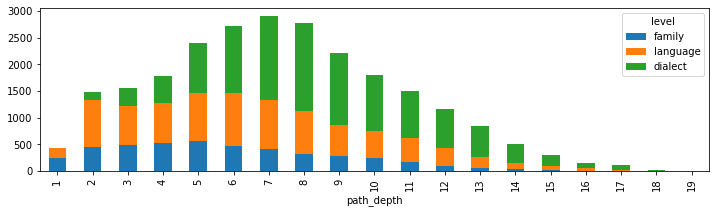

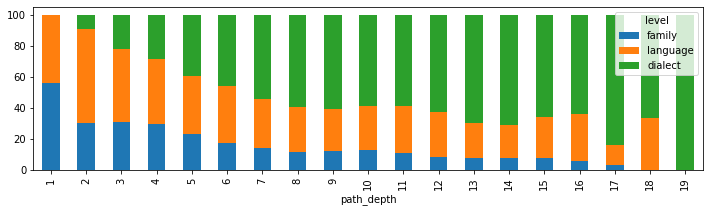

In [26]:
path_depth = File.path_depth()

select_path_depths = select([
        path_depth, treedb.Languoid.level, count().label('n_files'),
    ]).select_from(sa.join(File, treedb.Languoid, File.glottocode == treedb.Languoid.id))\
    .group_by(path_depth, treedb.Languoid.level)\
    .order_by('path_depth', 'level')

_ = read_sql(select_path_depths, index_col=['path_depth', 'level'])\
    .unstack(fill_value=0).droplevel(0, axis='columns')[list(treedb.LEVEL)]

_.plot.bar(stacked=True, figsize=(12, 3))

(100 * _.div(_.sum(axis='columns'), axis='rows')).plot.bar(stacked=True, figsize=(12, 3));

SELECT _file.size AS file_size, count(*) AS n_files 
FROM _file GROUP BY _file.size ORDER BY file_size
()


,file_size
min,63.0
max,46286.0


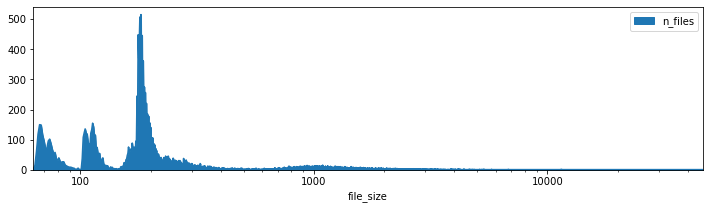

In [27]:
file_size = File.size.label('file_size')

select_file_sizes = select([
        file_size, count().label('n_files'),
    ]).group_by(file_size).order_by('file_size')

_ = read_sql(select_file_sizes, index_col='file_size')

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().loc[['min', 'max']]

SELECT n_values, count(*) AS n_files 
FROM (SELECT _file.glottocode AS glottocode, count(DISTINCT _value.option_id) AS n_values 
FROM _file JOIN _value ON _file.id = _value.file_id GROUP BY _file.glottocode) GROUP BY n_values ORDER BY n_values
()


,n_values
min,2.0
max,36.0


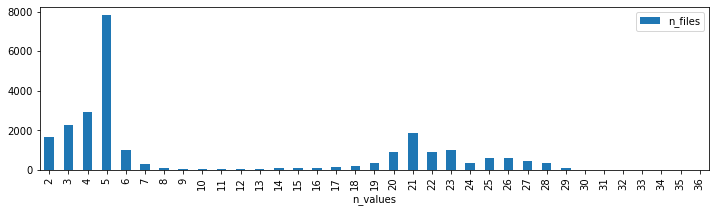

In [28]:
file_nvalues = select([
        File.glottocode, count(Value.option_id.distinct()).label('n_values'),
    ]).select_from(sa.join(File, Value))\
    .group_by(File.glottocode).c.n_values

select_nvalues = select([
        file_nvalues, count().label('n_files'),
    ]).group_by(file_nvalues).order_by(file_nvalues)

_ = read_sql(select_nvalues, index_col=['n_values'])

_.plot.bar(figsize=(12, 3))
_.index.to_series().describe().to_frame().loc[['min', 'max']]

SELECT length(_value.value) AS value_length, count(*) AS n_values 
FROM _value GROUP BY length(_value.value) ORDER BY value_length
()


,value_length
min,1.0
max,6215.0


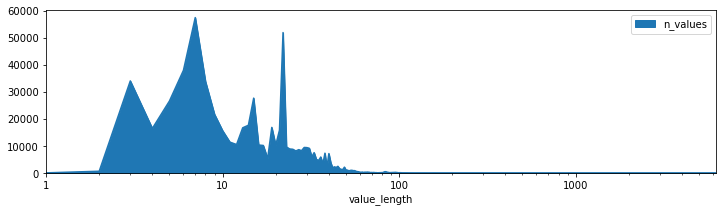

In [29]:
value_length = sa.func.length(Value.value).label('value_length')

select_value_length = select([
        value_length, count().label('n_values'),
    ]).group_by(value_length).order_by('value_length')

_ = read_sql(select_value_length, index_col='value_length')

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().loc[['min', 'max']]

In [30]:
%time raw.print_stats()

SELECT _option.section, _option.option, count(*) AS n 
FROM _option JOIN _value ON _option.id = _value.option_id GROUP BY _option.section, _option.option ORDER BY _option.section, n DESC
()


altnames               multitree              54,640
altnames               hhbib_lgcode           27,933
altnames               lexvo                  26,031
altnames               elcat                  23,412
altnames               aiatsis                6,542
altnames               wals                   2,441
altnames               wals other             2,097
altnames               moseley & asher (1994) 2,089
altnames               ruhlen (1987)          2,007
altnames               glottolog              1,093
altnames               ethnologue             2
classification         subrefs                14,993
classification         sub                    11,490
classification         familyrefs             693
classification         family                 206
core                   links                  28,887
core                   name                   24,701
core                   level                  24,701
core                   macroareas             18,513
core      

## languoid

In [31]:
FAMILY, LANGUAGE, DIALECT = LEVEL = treedb.LEVEL

Languoid = treedb.Languoid

print_sql(Languoid)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'languoid')
SELECT count(*) AS n_languoids 
FROM languoid
()


CREATE TABLE languoid (
	id VARCHAR(8) NOT NULL CHECK (length(id) = 8), 
	name VARCHAR NOT NULL CHECK (name != ''), 
	level VARCHAR(8) NOT NULL, 
	parent_id VARCHAR(8), 
	hid TEXT CHECK (length(hid) >= 3), 
	iso639_3 VARCHAR(3) CHECK (length(iso639_3) = 3), 
	latitude FLOAT CHECK (latitude BETWEEN -90 AND 90), 
	longitude FLOAT CHECK (longitude BETWEEN -180 AND 180), 
	PRIMARY KEY (id), 
	CHECK ((latitude IS NULL) = (longitude IS NULL)), 
	UNIQUE (name), 
	CHECK (level IN ('family', 'language', 'dialect')), 
	FOREIGN KEY(parent_id) REFERENCES languoid (id), 
	UNIQUE (hid), 
	UNIQUE (iso639_3)
)
24701


In [32]:
read_sql(select([Languoid]).limit(5), index_col='id')

SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid
 LIMIT ? OFFSET ?
(5, 0)


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
abin1243,Abinomn,language,None,bsa,bsa,-2.922810,138.891000
abis1238,Aewa,language,None,ash,ash,-1.284096,-75.084405
abkh1242,Abkhaz-Adyge,family,None,None,None,NaN,NaN
abkh1243,Abkhaz-Abaza,family,abkh1242,None,None,NaN,NaN
abaz1241,Abaza,language,abkh1243,abq,abq,44.250000,42.000000


In [33]:
read_sql(select([Languoid]).order_by('id').limit(5), index_col='id')

SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.id
 LIMIT ? OFFSET ?
(5, 0)


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
3adt1234,3Ad-Tekles,dialect,nort3292,None,None,NaN,NaN
aala1237,Aalawa,dialect,ramo1244,None,None,NaN,NaN
aant1238,Aantantara,dialect,nort2920,None,None,NaN,NaN
aari1238,Aari-Gayil,family,ahkk1235,aiz,aiz,NaN,NaN
aari1239,Aari,language,aari1238,aiw,aiw,5.95034,36.5721


In [34]:
read_sql(select([Languoid]).order_by('name').limit(5), index_col='id')

SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.name
 LIMIT ? OFFSET ?
(5, 0)


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
gang1269,!Gã!nge,dialect,sero1239,None,None,NaN,NaN
kwii1241,!Kwi,family,tuuu1241,None,None,NaN,NaN
oung1238,!O!ung,language,book1242,oun,oun,-15.3,14.35
abda1238,'Abd Al-Kuri,dialect,soqo1240,None,None,NaN,NaN
aden1242,'Aden,dialect,jude1267,None,None,NaN,NaN


In [35]:
Child, Parent = (sa.orm.aliased(Languoid, name=n) for n in ('child', 'parent'))

select_parent_levels = select([
        Child.level.label('child_level'),
        Parent.level.label('parent_level'),
        count().label('n_languoids'),
    ]).select_from(sa.outerjoin(Child, Parent, Child.parent_id == Parent.id))\
    .group_by(Child.level, Parent.level)\
    .order_by('child_level', 'parent_level')

read_sql(select_parent_levels, index_col=['child_level', 'parent_level'])\
    .unstack(fill_value=0).assign(all=lambda x: x.sum(axis='columns'))\
    .pipe(lambda x: x.append(x.sum().rename('all')))

SELECT child.level AS child_level, parent.level AS parent_level, count(*) AS n_languoids 
FROM languoid AS child LEFT OUTER JOIN languoid AS parent ON child.parent_id = parent.id GROUP BY child.level, parent.level ORDER BY child_level, parent_level
()


n_languoids                            all
parent_level         NaN dialect family language       
child_level                                            
dialect                0    1611      0    10173  11784
family               241       0   4170        0   4411
language             188       0   8318        0   8506
all                  429    1611  12488    10173  24701

In [36]:
select_nisos = select([
        Languoid.level.label('level'),
        count().label('n_languoids'),
        count(Languoid.iso639_3).label('n_isos'),
    ]).group_by(Languoid.level).order_by('level')

read_sql(select_nisos, index_col=['level'])\
    .assign(ratio=lambda x: 100 * x['n_isos'] / x['n_languoids'])

SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.iso639_3) AS n_isos 
FROM languoid GROUP BY languoid.level ORDER BY level
()


,n_languoids,n_isos,ratio
level,,,
dialect,11784,158,1.340801
family,4411,46,1.042847
language,8506,7811,91.829297


In [37]:
select_nlocations = select([
        Languoid.level.label('level'),
        count().label('n_languoids'),
        count(Languoid.latitude).label('n_locations'),
    ]).group_by(Languoid.level).order_by('level')

read_sql(select_nlocations, index_col=['level'])\
    .assign(ratio=lambda x: 100 * x['n_locations'] / x['n_languoids'])

SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.latitude) AS n_locations 
FROM languoid GROUP BY languoid.level ORDER BY level
()


,n_languoids,n_locations,ratio
level,,,
dialect,11784,239,2.028174
family,4411,16,0.362730
language,8506,8046,94.592053


SELECT languoid.latitude, languoid.longitude 
FROM languoid 
WHERE languoid.level = ?
('language',)


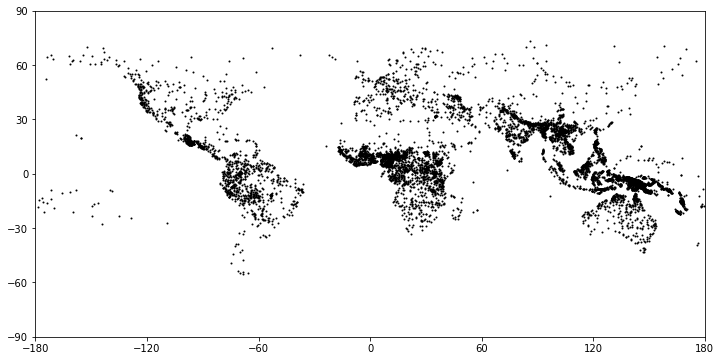

In [38]:
select_latlon = select([
        Languoid.latitude, Languoid.longitude
    ]).where(Languoid.level == LANGUAGE)

latitudes, longitudes = zip(*select_latlon.execute())
    
plt.figure(figsize=(12, 6))
plt.axis([-180, 180, -90, 90])
plt.xticks(range(-180, 181, 60))
plt.yticks(range(-90, 91, 30))
plt.scatter(longitudes, latitudes, 1, 'black');

WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, child.parent_id AS parent_id 
FROM languoid AS child 
WHERE child.parent_id IS NOT NULL UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id 
WHERE parent.parent_id IS NOT NULL)
 SELECT family.id AS family_id, count(child.id) AS n_languages 
FROM languoid AS family LEFT OUTER JOIN (languoid AS child JOIN tree ON tree.child_id = child.id) ON tree.parent_id = family.id 
WHERE family.parent_id IS NULL AND family.level = ? AND child.level = ? GROUP BY family.id 
HAVING count(child.id) >= ? ORDER BY n_languages
('family', 'language', 100)


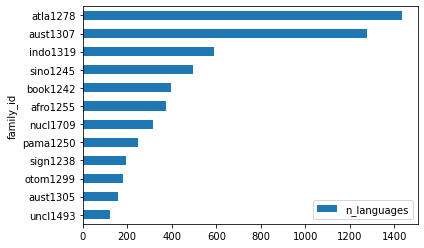

In [39]:
tree = treedb.Languoid.tree()

Family = sa.orm.aliased(treedb.Languoid, name='family')

n_languages = count(Child.id).label('n_languages')

select_family_nlanguages = select([
        Family.id.label('family_id'),
        n_languages,
    ]).select_from(sa.outerjoin(Family,
        sa.join(Child, tree, tree.c.child_id == Child.id),
        tree.c.parent_id == Family.id))\
    .where(Family.parent_id == None)\
    .where(Family.level == FAMILY)\
    .where(Child.level == LANGUAGE)\
    .group_by(Family.id)

select_top_families = select_family_nlanguages\
    .having(n_languages >= 100)\
    .order_by('n_languages')

read_sql(select_top_families, index_col=['family_id']).plot.barh();

WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, child.parent_id AS parent_id 
FROM languoid AS child 
WHERE child.parent_id IS NOT NULL UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id 
WHERE parent.parent_id IS NOT NULL)
 SELECT n_languages AS family_size, count(*) AS n_families 
FROM (SELECT family.id AS family_id, count(child.id) AS n_languages 
FROM languoid AS family LEFT OUTER JOIN (languoid AS child JOIN tree ON tree.child_id = child.id) ON tree.parent_id = family.id 
WHERE family.parent_id IS NULL AND family.level = ? AND child.level = ? GROUP BY family.id) GROUP BY n_languages ORDER BY family_size
('family', 'language')


,family_size
min,2.0
max,1432.0


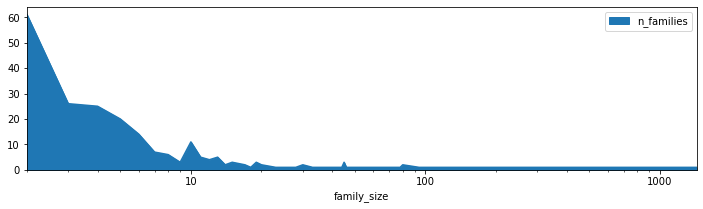

In [40]:
family_size = select_family_nlanguages.c.n_languages.label('family_size')

select_family_sizes = select([
        family_size, count().label('n_families'),
    ]).group_by(family_size).order_by('family_size')

_ = read_sql(select_family_sizes, index_col=['family_size'])

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().loc[['min', 'max']]

In [41]:
levels = sa.union_all(*
        (select([sa.literal(l).label('level')]) for l in LEVEL)
    ).cte(name='levels')

select_nchildren = select([
        Parent.id.label('parent_id'),
        Parent.level.label('parent_level'),
        levels.c.level.label('child_level'),
        count(Child.id).label('n_children'),
    ]).select_from(
        sa.join(Parent, levels, sa.true())
        .outerjoin(Child, sa.and_(
            Child.parent_id == Parent.id, Child.level == levels.c.level)))\
    .group_by(Parent.id, Parent.level, levels.c.level)

read_sql(select_nchildren)\
    .pivot_table(index='parent_level', columns='child_level', values='n_children',
                 aggfunc=['sum', 'max', 'mean'], fill_value=0)

WITH levels AS 
(SELECT ? AS level UNION ALL SELECT ? AS level UNION ALL SELECT ? AS level)
 SELECT parent.id AS parent_id, parent.level AS parent_level, levels.level AS child_level, count(child.id) AS n_children 
FROM languoid AS parent JOIN levels ON 1 LEFT OUTER JOIN languoid AS child ON child.parent_id = parent.id AND child.level = levels.level GROUP BY parent.id, parent.level, levels.level
('family', 'language', 'dialect')


sum                     max                      mean  \
child_level  dialect family language dialect family language   dialect   
parent_level                                                             
dialect         1611      0        0      22      0        0  0.136711   
family             0   4170     8318       0     44      395  0.000000   
language       10173      0        0      32      0        0  1.195979   

                                 
child_level     family language  
parent_level                     
dialect       0.000000  0.00000  
family        0.945364  1.88574  
language      0.000000  0.00000

In [42]:
select_ndescendants = select([
        Parent.id.label('parent_id'),
        Parent.level.label('parent_level'),
        count(Child.id).label('n_descendants'),
    ]).select_from(
        sa.join(Child, tree, tree.c.child_id == Child.id)
        .join(Parent, tree.c.parent_id == Parent.id))\
    .group_by(Parent.id, Parent.level)\
    .alias()

n_descendants = select_ndescendants.c.n_descendants
d_min = sa.func.min(n_descendants).label('min')
d_max = sa.func.max(n_descendants).label('max')
d_mean = (sa.func.sum(n_descendants).cast(sa.Float) / count(n_descendants)).label('mean')

select_level_mean_descendants = select([
        select_ndescendants.c.parent_level,
        d_min, d_max, d_mean,
    ]).group_by(select_nchildren.c.parent_level).order_by(select_nchildren.c.parent_level)

select_total_mean_descendants = select([
        sa.literal('total').label('parent_level'),
        d_min, d_max, d_mean,
    ])

select_mean_descendants = [select_level_mean_descendants, select_total_mean_descendants]

_ = pd.concat([read_sql(q, index_col=['parent_level']) for q in select_mean_descendants])
_.columns = pd.MultiIndex.from_product([['n_descendants'], _.columns])
_

WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, child.parent_id AS parent_id 
FROM languoid AS child 
WHERE child.parent_id IS NOT NULL UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id 
WHERE parent.parent_id IS NOT NULL)
 SELECT anon_1.parent_level, min(anon_1.n_descendants) AS min, max(anon_1.n_descendants) AS max, CAST(sum(anon_1.n_descendants) AS FLOAT) / count(anon_1.n_descendants) AS mean 
FROM (SELECT parent.id AS parent_id, parent.level AS parent_level, count(child.id) AS n_descendants 
FROM languoid AS child JOIN tree ON tree.child_id = child.id JOIN languoid AS parent ON tree.parent_id = parent.id GROUP BY parent.id, parent.level) AS anon_1 GROUP BY parent_level ORDER BY parent_level
()
WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, child.parent_id AS parent_id 
FROM languoid AS child 
WHERE child.parent_id IS NOT NULL UNION ALL SELE

n_descendants                 
                       min   max       mean
parent_level                               
dialect                  1    57   4.763103
family                   1  4722  32.503514
language                 1   125   4.187633
total                    1  4722  20.440016

## macroarea

In [43]:
Macroarea = treedb.models.Macroarea
languoid_macroarea = treedb.models.languoid_macroarea

print_sql(Macroarea)
print_sql(languoid_macroarea)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'macroarea')
SELECT count(*) AS n_macroareas 
FROM macroarea
()
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'languoid_macroarea')
SELECT count(*) AS n_languoid_macroareas 
FROM languoid_macroarea
()


CREATE TABLE macroarea (
	name VARCHAR(13) NOT NULL, 
	PRIMARY KEY (name), 
	CHECK (name IN ('Africa', 'Australia', 'Eurasia', 'North America', 'Papunesia', 'South America'))
)
6
CREATE TABLE languoid_macroarea (
	languoid_id VARCHAR(8) NOT NULL, 
	macroarea_name VARCHAR(13) NOT NULL, 
	PRIMARY KEY (languoid_id, macroarea_name), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	FOREIGN KEY(macroarea_name) REFERENCES macroarea (name)
)
18513


In [44]:
select_macroarea_nlanguages = select([
        Macroarea.name.label('macroarea'),
        count().label('n_languages'),
    ]).select_from(sa.outerjoin(Macroarea, sa.join(languoid_macroarea, Languoid)))\
    .where(Languoid.level == LANGUAGE)\
    .group_by(Macroarea.name)\
    .order_by(sa.desc('n_languages'))

read_sql(select_macroarea_nlanguages, index_col='macroarea')

SELECT macroarea.name AS macroarea, count(*) AS n_languages 
FROM macroarea LEFT OUTER JOIN (languoid_macroarea JOIN languoid ON languoid.id = languoid_macroarea.languoid_id) ON macroarea.name = languoid_macroarea.macroarea_name 
WHERE languoid.level = ? GROUP BY macroarea.name ORDER BY n_languages DESC
('language',)


,n_languages
macroarea,
Africa,2344
Papunesia,2206
Eurasia,1971
North America,786
South America,711
Australia,385


In [45]:
select_multiarea_languages = select([
        Languoid.id, Languoid.name,
        sa.func.group_concat(Macroarea.name, ', ').label('macroareas')
    ]).select_from(sa.join(Languoid, languoid_macroarea).join(Macroarea))\
    .where(Languoid.level == LANGUAGE)\
    .group_by(Languoid.id)\
    .having(count() > 1)\
    .order_by('id')
    
read_sql(select_multiarea_languages)

SELECT languoid.id, languoid.name, group_concat(macroarea.name, ?) AS macroareas 
FROM languoid JOIN languoid_macroarea ON languoid.id = languoid_macroarea.languoid_id JOIN macroarea ON macroarea.name = languoid_macroarea.macroarea_name 
WHERE languoid.level = ? GROUP BY languoid.id 
HAVING count(*) > ? ORDER BY languoid.id
(', ', 'language', 1)


,id,name,macroareas


## country

In [46]:
Country = treedb.models.Country
languoid_country = treedb.models.languoid_country

print_sql(Country)
print_sql(languoid_country)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'country')
SELECT count(*) AS n_countrys 
FROM country
()
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'languoid_country')
SELECT count(*) AS n_languoid_countrys 
FROM languoid_country
()


CREATE TABLE country (
	id VARCHAR(2) NOT NULL CHECK (length(id) = 2), 
	name TEXT NOT NULL CHECK (name != ''), 
	PRIMARY KEY (id), 
	UNIQUE (name)
)
226
CREATE TABLE languoid_country (
	languoid_id VARCHAR(8) NOT NULL, 
	country_id VARCHAR(2) NOT NULL, 
	PRIMARY KEY (languoid_id, country_id), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	FOREIGN KEY(country_id) REFERENCES country (id)
)
10979


In [47]:
select_country_nlanguages = select([
        Country.name.label('country'),
        count().label('n_languages'),
    ]).select_from(sa.outerjoin(Country, sa.join(languoid_country, Languoid)))\
    .where(Languoid.level == LANGUAGE)\
    .group_by(Country.id)\
    .order_by(sa.desc('n_languages'))\
    .limit(10)

read_sql(select_country_nlanguages, index_col='country')

SELECT country.name AS country, count(*) AS n_languages 
FROM country LEFT OUTER JOIN (languoid_country JOIN languoid ON languoid.id = languoid_country.languoid_id) ON country.id = languoid_country.country_id 
WHERE languoid.level = ? GROUP BY country.id ORDER BY n_languages DESC
 LIMIT ? OFFSET ?
('language', 10, 0)


,n_languages
country,
Papua New Guinea,896
Indonesia,744
Nigeria,573
India,499
China,398
Australia,392
Mexico,328
Brazil,324
United States,321


In [48]:
select_lc = select([
        Languoid.id, Languoid.name, Country.id.label('country'),
    ]).select_from(sa.join(Languoid, languoid_country).join(Country))\
    .where(Languoid.level == LANGUAGE)\
    .order_by(Languoid.id, 'country')

select_multicountry_languages = select([
        select_lc.c.id, select_lc.c.name,
        count().label('n_countries'),
        sa.func.group_concat(select_lc.c.country, ', ').label('countries')
    ]).group_by(select_lc.c.id, select_lc.c.name)\
    .having(count() > 1)\
    .order_by(sa.desc('n_countries'), select_lc.c.id)\
    .limit(10)
    
read_sql(select_multicountry_languages, index_col='id')

SELECT id, name, count(*) AS n_countries, group_concat(country, ?) AS countries 
FROM (SELECT languoid.id AS id, languoid.name AS name, country.id AS country 
FROM languoid JOIN languoid_country ON languoid.id = languoid_country.languoid_id JOIN country ON country.id = languoid_country.country_id 
WHERE languoid.level = ? ORDER BY languoid.id, country) GROUP BY id, name 
HAVING count(*) > ? ORDER BY n_countries DESC, id
 LIMIT ? OFFSET ?
(', ', 'language', 1, 10, 0)


,name,n_countries,countries
id,,,
stan1288,Spanish,30,"AD, AR, BO, BR, BZ, CL, CO, CR, CU, DO, EC, ES..."
stan1293,English,26,"AU, BM, BR, BZ, CA, CK, CU, DO, FK, GB, GI, GP..."
stan1318,Standard Arabic,25,"AE, BH, DJ, DZ, EG, ER, IL, IQ, JO, KM, KW, LB..."
amer1248,American Sign Language,22,"BB, BF, BJ, BO, CA, CD, CF, CI, CN, GA, GH, JM..."
east2295,Eastern Yiddish,22,"AR, AU, BE, BY, CA, CR, EE, HU, IL, LT, LV, MD..."
russ1263,Russian,19,"BY, CN, EE, FI, GE, KG, KP, KZ, LT, LV, MD, MN..."
stan1295,German,16,"AT, BE, CH, CZ, DE, DK, FR, HU, IT, LI, LU, NL..."
port1283,Portuguese,15,"AD, AR, BO, BR, CO, ES, FR, GF, GY, PE, PT, PY..."
sint1235,Sinte Romani,13,"AT, CH, CZ, DE, FR, HR, IT, KZ, ME, NL, PL, RS..."


## link

In [49]:
Link = treedb.models.Link

print_sql(Link)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'link')
SELECT count(*) AS n_links 
FROM link
()


CREATE TABLE link (
	languoid_id VARCHAR(8) NOT NULL, 
	ord INTEGER NOT NULL CHECK (ord >= 1), 
	url TEXT NOT NULL CHECK (url != ''), 
	title TEXT CHECK (title != ''), 
	scheme TEXT, 
	PRIMARY KEY (languoid_id, ord), 
	UNIQUE (languoid_id, url), 
	CHECK (substr(url, 1, length(scheme) + 3) = scheme || '://'), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	CHECK (scheme IN ('http', 'https'))
)
28887


SELECT link.scheme AS link_scheme, count(*) AS n_links 
FROM link GROUP BY link.scheme ORDER BY link_scheme
()


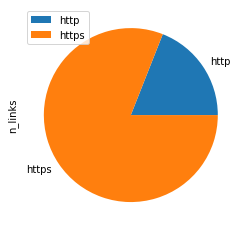

In [50]:
select_scheme_nlinks = select([
        Link.scheme.label('link_scheme'), count().label('n_links'),
    ]).group_by(Link.scheme).order_by('link_scheme')

read_sql(select_scheme_nlinks, index_col=['link_scheme']).plot.pie(y='n_links');

SELECT link.url 
FROM link
()


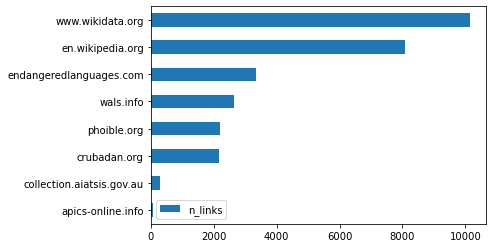

In [51]:
hosts = collections.Counter(urlparse(u).hostname for u, in select([Link.url]).execute())

pd.DataFrame.from_dict(hosts, orient='index', columns=['n_links'])\
    .sort_values(by='n_links').plot.barh();

## denormalized

In [52]:
%time treedb.hash_csv(treedb.get_query())

WITH RECURSIVE tree(child_id, parent_id, steps, terminal) AS 
(SELECT child.id AS child_id, child.id AS parent_id, ? AS steps, child.parent_id IS NULL AS terminal 
FROM languoid AS child UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id, tree.steps + ? AS steps, grandparent.parent_id IS NULL AS terminal 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id LEFT OUTER JOIN languoid AS grandparent ON grandparent.id = parent.parent_id 
WHERE parent.parent_id IS NOT NULL)
 SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, (SELECT group_concat(path_part, ?) AS group_concat_1 
FROM (SELECT tree.parent_id AS path_part 
FROM tree 
WHERE tree.child_id = languoid.id ORDER BY tree.steps DESC)) AS path, (SELECT tree.parent_id 
FROM tree 
WHERE tree.child_id = languoid.id AND tree.steps > ? AND tree.terminal = 1) AS family_id, (SELECT tree.parent_id 
FROM tree 
WHERE tree.child_id = languoid.id AND languoid.level = ? AND (EXISTS (SELECT * 
FRO

(0, 1, '/', 0, 'dialect', 'language', ', ', ', ', '(%s)[%s]', ', ', '**%s:%s**:%s<trigger "%s">', '**s:%s**:%s', '**%s:%s**<trigger "%s">', '**%s:%s**', ', ', 'glottolog', '', 2, 3, '%s [%s]', ', ', 'aiatsis', '', 2, 3, '%s [%s]', ', ', 'elcat', '', 2, 3, '%s [%s]', ', ', 'ethnologue', '', 2, 3, '%s [%s]', ', ', 'glottolog', '', 2, 3, '%s [%s]', ', ', 'hhbib_lgcode', '', 2, 3, '%s [%s]', ', ', 'lexvo', '', 2, 3, '%s [%s]', ', ', 'moseley & asher (1994)', '', 2, 3, '%s [%s]', ', ', 'multitree', '', 2, 3, '%s [%s]', ', ', 'ruhlen (1987)', '', 2, 3, '%s [%s]', ', ', 'wals', '', 2, 3, '%s [%s]', ', ', 'wals other', ', ', 'lgcode', ', ', 'inlg', '**s:%s**:%s', '**%s:%s**', ', ', 'sub', '**s:%s**:%s', '**%s:%s**', ', ', 'family', ', ', 'endangeredlanguages', 'languagelandscape', 'multitree', 'wals', 'sub', 'family')


Wall time: 10.7 s


'c2344d313423c426d1c3d7a36b6f3283ab520453361f044b01c520b0c62cdd90'

In [53]:
#%time read_sql(treedb.get_query())